# Asennusmäärän ennustaminen

Tämä versio on lähinnä mallin testaamista varten.

- Käytetään koko dataa
- Lasketaan kuukausittainen asennusmäärä
- Valitaan opetusdata
- Tehdään ennuste
  - Multi-input, multioutput

## Kirjastot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import importlib.util
import sys
file_path = "../../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


## Esikäsittelijän ajaminen

In [2]:
cols = ['installation_date']
df_all = esik.esik(cols)


## Luodaan aikasarja

Aikasarjan indeksinä on kuukausi ja arvona kaikkien kyseisen kuukauden aikana tehtyjen asennusten määrä.

In [3]:
df = df_all.copy()
df['year-month'] = df['installation_date'].dt.strftime('%Y-%m')


In [4]:
value_counts_df = df['year-month'].value_counts().sort_index()
value_counts_df = pd.DataFrame({'year-month': value_counts_df.index, 'count': value_counts_df})
month_period = pd.period_range(start='1998-01-01', end='2019-12-01', freq='M').strftime('%Y-%m')
month = pd.DataFrame(data=month_period, columns=['year-month'], dtype='object')
merged = month.merge(value_counts_df, how='left', on='year-month')
df_year_month = merged.fillna(0)
df_year_month.index = month_period
display(df_year_month)


year-month    count
1998-01    1998-01      1.0
1998-02    1998-02      1.0
1998-03    1998-03      0.0
1998-04    1998-04      1.0
1998-05    1998-05      2.0
...            ...      ...
2019-08    2019-08  13816.0
2019-09    2019-09  13286.0
2019-10    2019-10  13239.0
2019-11    2019-11  13587.0
2019-12    2019-12  15062.0

[264 rows x 2 columns]

## Muokataan ja valitaan data mallia varten

Testataan mallia ensin pienellä osalla dataa. Valitaan data vuosilta 2013-2014 ja katsotaan halutaanko sitä muokata jotenkin mallia varten. Tässä on tehty vertailu eksponentiaalisesti painotettuun keskiarvoon ja liukuvaan keskiarvoon.

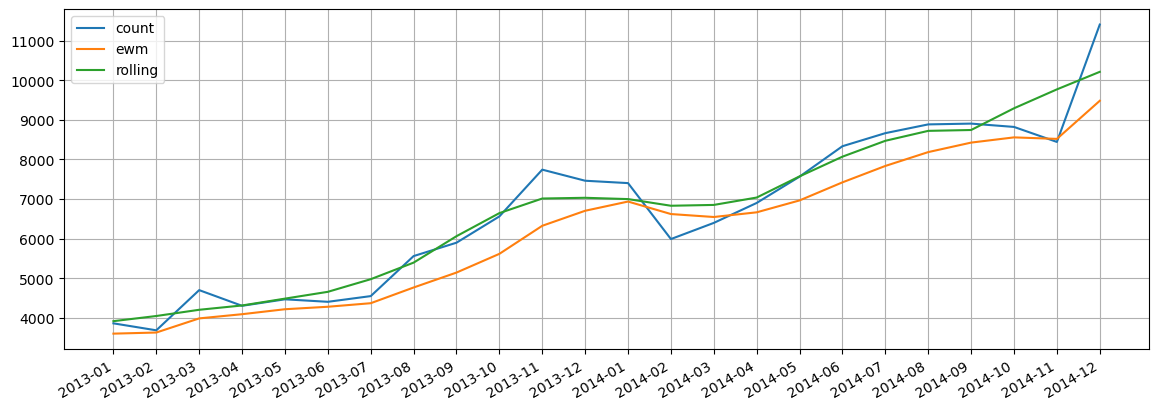

In [5]:
df = df_year_month.copy()

# Vertailut
df['ewm_count'] = df['count'].ewm(com=2).mean()
df['rolling_count'] = df['count'].rolling(5, min_periods=3, center=True).mean()

# Valitaan ajanjakso
start = 2013
n_years = 2


a = start - 1998
b = a + n_years
a = a * 12
b = b * 12
df = df.iloc[a:b,:]

# Piirto
def format_date(x1, pos=None):
  N = len(df)
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return df['year-month'].iloc[thisind]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['year-month'], df['count'], label='count')
ax.plot(df['year-month'], df['ewm_count'], label='ewm')
ax.plot(df['year-month'], df['rolling_count'],  label='rolling')
if n_years > 2:
  locator = mdates.AutoDateLocator(maxticks=8)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(format_date)
else:
  fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()


Valitaan liukuva keskiarvo, koska seuraa paremmin oikeaa käyrää ja pyöristää sopivasti.

In [6]:
df['count'] = df['rolling_count']
df.drop(['ewm_count', 'rolling_count'], axis=1, inplace=True)
df_ML = df.copy()

## Malli

Mahdollisimman yksinkertaisen mallin tehdäksemme määritetään seuraava testiajo näin:

- Käytetään äsken luotua DataFrame:ä (`df_ML`) testaamiseen
- Valitaan vuosi 2013 mallin opetusaineistoksi
- Valitaan mallin syötteeksi 6 kk vuoden 2014 alusta
- Tehdään 6 kk ennuste vuoden 2014 lopulle

### Funktio, jolla muodostetaan mallille annettava syöte ja odotettu tulos (input ja output)

In [7]:
# Source: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df_f = data.copy()
    
    i = 1
    while i < input_length:
        df_f[f'x_{i}'] = df_f['count'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df_f[f'y_{j}'] = df_f['count'].shift(-output_length-j)
        j = j + 1
        
    df_f = df_f.dropna(axis=0)
    
    return df_f

Käytetään edellä olevaa funktiota. Huomataan, että 'count' ja 'x' -sarakkeet ovat liukuvan keskiarvon mukaiset asennusmäärät 6 kk ajalta alkaen sarakkeen 'year-month' ilmaisemasta ajankohdasta. 'y' -sarakkeet ovat vastaavat arvot 6 seuraavalta kuukaudelta.

Lopulta rivillä '2014-01' on koko vuoden 2014 arvot.

In [8]:
input_len = 6
output_len = 6
seq_df = window_input_output(input_len, output_len, df_ML)
print(len(seq_df))
seq_df

13


year-month   count     x_1     x_2     x_3     x_4     x_5     y_0  \
2013-01    2013-01  3913.2  4043.4  4200.6  4309.4  4482.2  4654.2  4973.0   
2013-02    2013-02  4043.4  4200.6  4309.4  4482.2  4654.2  4973.0  5391.8   
2013-03    2013-03  4200.6  4309.4  4482.2  4654.2  4973.0  5391.8  6059.4   
2013-04    2013-04  4309.4  4482.2  4654.2  4973.0  5391.8  6059.4  6642.2   
2013-05    2013-05  4482.2  4654.2  4973.0  5391.8  6059.4  6642.2  7010.8   
2013-06    2013-06  4654.2  4973.0  5391.8  6059.4  6642.2  7010.8  7029.2   
2013-07    2013-07  4973.0  5391.8  6059.4  6642.2  7010.8  7029.2  6996.4   
2013-08    2013-08  5391.8  6059.4  6642.2  7010.8  7029.2  6996.4  6828.2   
2013-09    2013-09  6059.4  6642.2  7010.8  7029.2  6996.4  6828.2  6849.0   
2013-10    2013-10  6642.2  7010.8  7029.2  6996.4  6828.2  6849.0  7035.4   
2013-11    2013-11  7010.8  7029.2  6996.4  6828.2  6849.0  7035.4  7570.4   
2013-12    2013-12  7029.2  6996.4  6828.2  6849.0  7035.4  7570.4  8068.0   
2014-01    2014-01  6996.4  6828.2  6849.0  7035.4  7570.4  8068.0  8468.8   

            y_1     y_2     y_3     y_4      y_5  
2013-01  5391.8  6059.4  6642.2  7010.8   7029.2  
2013-02  6059.4  6642.2  7010.8  7029.2   6996.4  
2013-03  6642.2  7010.8  7029.2  6996.4   6828.2  
2013-04  7010.8  7029.2  6996.4  6828.2   6849.0  
2013-05  7029.2  6996.4  6828.2  6849.0   7035.4  
2013-06  6996.4  6828.2  6849.0  7035.4   7570.4  
2013-07  6828.2  6849.0  7035.4  7570.4   8068.0  
2013-08  6849.0  7035.4  7570.4  8068.0   8468.8  
2013-09  7035.4  7570.4  8068.0  8468.8   8719.8  
2013-10  7570.4  8068.0  8468.8  8719.8   8741.4  
2013-11  8068.0  8468.8  8719.8  8741.4   9290.0  
2013-12  8468.8  8719.8  8741.4  9290.0   9767.4  
2014-01  8719.8  8741.4  9290.0  9767.4  10210.8

### Train test split

Edellä tehty muokkaus supisti käytettävissä olevan datan 13 riviin. Kuten edellä määritettiin valitaan opetusaineistoksi kaikki rivit vuodelta 2013. Huomataan toki, että käytännössä opetusaineistoon menee dataa myös vuodelta 2014.

Viimeinen rivi jää testausta varten.

In [9]:
X_cols = [col for col in seq_df.columns if col.startswith('x_')]

X_cols.insert(0, 'count')

y_cols = [col for col in seq_df.columns if col.startswith('y_')]

test_size = 1

X_train = seq_df[X_cols][:-test_size].values
y_train = seq_df[y_cols][:-test_size].values

X_test = seq_df[X_cols][-test_size:].values
y_test = seq_df[y_cols][-test_size:].values

# Arvojen tulostelua tarkistusta varten

#print("X_train, shape:", X_train.shape)
#display(X_train)
#print("X_test, shape:", X_test.shape)
#display(X_test)
#print("y_train, shape:", y_train.shape)
#display(y_train)
#print("y_test, shape:", y_test.shape)
#display(y_test)


### Mallien koulutus

Käytetään kahta malllia.

In [10]:
dt_seq = DecisionTreeRegressor(random_state=9)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)
#print("dt_seq_preds. shape:", dt_seq_preds.shape)
#dt_seq_preds

In [11]:
rf_seq = RandomForestRegressor(random_state=9)

rf_seq.fit(X_train, y_train)

rf_seq_preds = rf_seq.predict(X_test)


## Tulosten piirto

Piirretään tulokset.

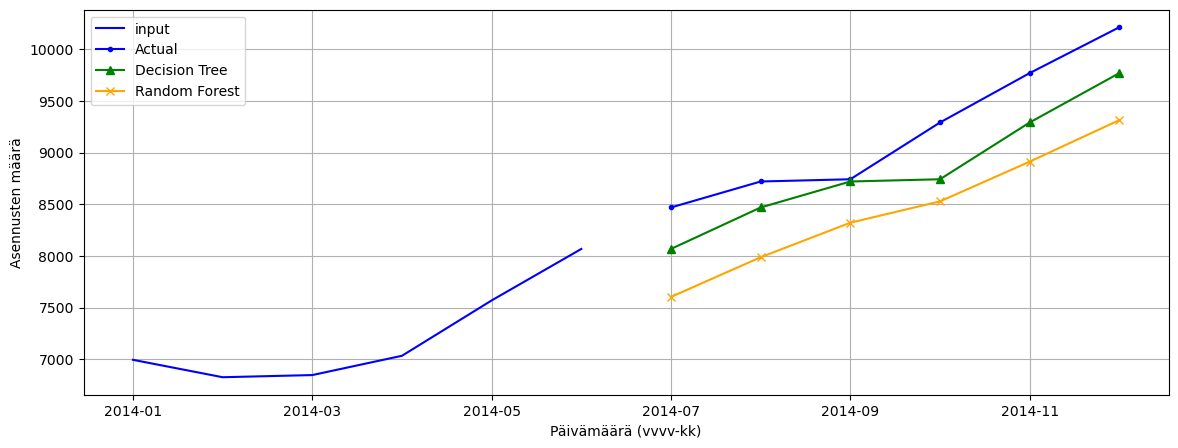

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))

a = input_len
b = input_len + output_len

N = len(seq_df)

def format_date_2(x1, pos=None):
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return df_ML['year-month'].iloc[N - test_size + thisind]

ax.plot(np.arange(0, a, 1), X_test[0], 'b-', label='input')
ax.plot(np.arange(a, b, 1), y_test[0], marker='.', color='blue', label='Actual')
ax.plot(np.arange(a, b, 1), dt_seq_preds[0], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(a, b, 1), rf_seq_preds[0], marker='x', color='orange', label='Random Forest')

locator = mdates.AutoDateLocator(maxticks=8)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date_2)
#fig.autofmt_xdate()
ax.set_xlabel('Päivämäärä (vvvv-kk)')
ax.set_ylabel('Asennusten määrä')
ax.legend()
ax.grid()
plt.show()


Mallit hyödyntävät ilmeisen hyvin opetusaineiston dataa. `Decision Tree`:n ennuste on käytännössä toteutuneita arvoja kuukauden myöhässä. Tämä johtuu siitä, että opetusaineiston viimeinen rivi ulottui käytännössä marraskuuhun 2014 asti. Mallia voisi olla mielenkiintoisempi muuttaa ennustamaan pidempi aika.

In [13]:
res = pd.DataFrame({'Actual': df_ML['count'].tail(6), 'Decision Tree': dt_seq_preds[0], 'Random Forest': rf_seq_preds[0]})
#df_ML['count'].tail(12)
res

Actual  Decision Tree  Random Forest
2014-07   8468.8         8068.0       7604.306
2014-08   8719.8         8468.8       7987.868
2014-09   8741.4         8719.8       8321.442
2014-10   9290.0         8741.4       8527.570
2014-11   9767.4         9290.0       8911.588
2014-12  10210.8         9767.4       9313.114